In [57]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

train = pd.read_csv("train.csv")

In [58]:
Q1 = train['Price'].quantile(0.25)
Q3 = train['Price'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = 400000
lower_bound = 0

train = train[(train['Price'] >= lower_bound) & (train['Price'] <= upper_bound)]

In [59]:
print(train.shape)
print(train.duplicated().sum())
tabela = pd.DataFrame({
    'Unique':train.nunique(),
    'Null':train.isna().sum(),
    'NullPercent':train.isna().sum() / len(train),
    'Types':train.dtypes.values
})
display(tabela)

(19234, 18)
313


Unique  Null  NullPercent    Types
ID                 18921     0          0.0    int64
Price               2312     0          0.0    int64
Levy                 559     0          0.0   object
Manufacturer          64     0          0.0   object
Model               1588     0          0.0   object
Prod. year            54     0          0.0    int64
Category              11     0          0.0   object
Leather interior       2     0          0.0   object
Fuel type              7     0          0.0   object
Engine volume        107     0          0.0   object
Mileage             7686     0          0.0   object
Cylinders             13     0          0.0  float64
Gear box type          4     0          0.0   object
Drive wheels           3     0          0.0   object
Doors                  3     0          0.0   object
Wheel                  2     0          0.0   object
Color                 16     0          0.0   object
Airbags               17     0          0.0    int64

In [60]:
train.drop_duplicates(inplace=True)


In [61]:
train['Levy'] = train['Levy'].str.replace('-','0')
train['Levy'] = train['Levy'].astype(int)
train.replace({'rover':'land rover'}, inplace=True)
train = train[train['Levy'] != 'სხვა']
train = train[train['Levy'] !='0']
train['Mileage'] = train['Mileage'].str.replace('km','')
train['Mileage'] = train['Mileage'].astype(int)
train = train[train['Price']<=400000]
train.drop(['ID','Doors'],axis=1, inplace=True)

In [62]:
# selecionando dados categóricos
cat = train.select_dtypes(include='O')
cat.columns

# função para transformar texto
def text_lower(text):
    text = text.lower()
    return text

# transformando texto
for c in cat.columns:
    train[c] = train[c].apply(lambda text: text_lower(text))
    

In [63]:
# copiando dados originais para a preparação do treinamento dos modelos
df = train.copy()

In [64]:
cat = df.select_dtypes(include='O')

# transformando dados categóricos em numéricos
le = LabelEncoder()
encode = list(cat)
df[encode] = df[encode].apply(lambda col: le.fit_transform(col))
df[encode]

Manufacturer  Model  Category  Leather interior  Fuel type  \
0                31   1202         4                 1          2   
1                 8    623         4                 0          5   
2                21    658         3                 0          5   
3                16    629         4                 1          2   
4                21    658         3                 1          5   
...             ...    ...       ...               ...        ...   
19232            35    430         1                 1          0   
19233            23   1270         9                 1          5   
19234            23   1377         4                 1          1   
19235             8    386         4                 1          1   
19236            23   1270         9                 1          2   

       Engine volume  Gear box type  Drive wheels  Wheel  Color  
0                 63              0             0      0     12  
1                 56              2             0      0      1  
2                 22              3             1      1      1  
3                 46              0             0      0     14  
4                 22              0             1      0     12  
...              ...            ...           ...    ...    ...  
19232             37              1             2      0     12  
19233             44              2             1      0     11  
19234             36              0             1      0      7  
19235             36              0             1      0      1  
19236             44              0             1      0     14  

[18921 rows x 10 columns]

<Axes: >

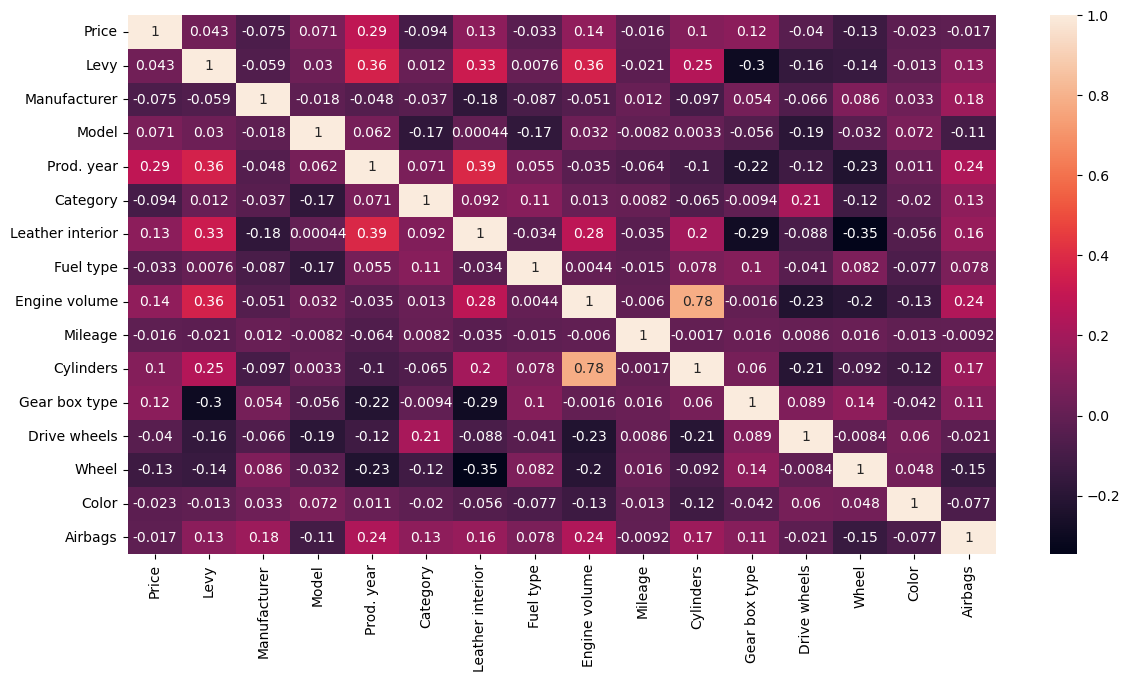

In [65]:
plt.figure(figsize=(14,7))
sns.heatmap(df.corr(),annot=True)

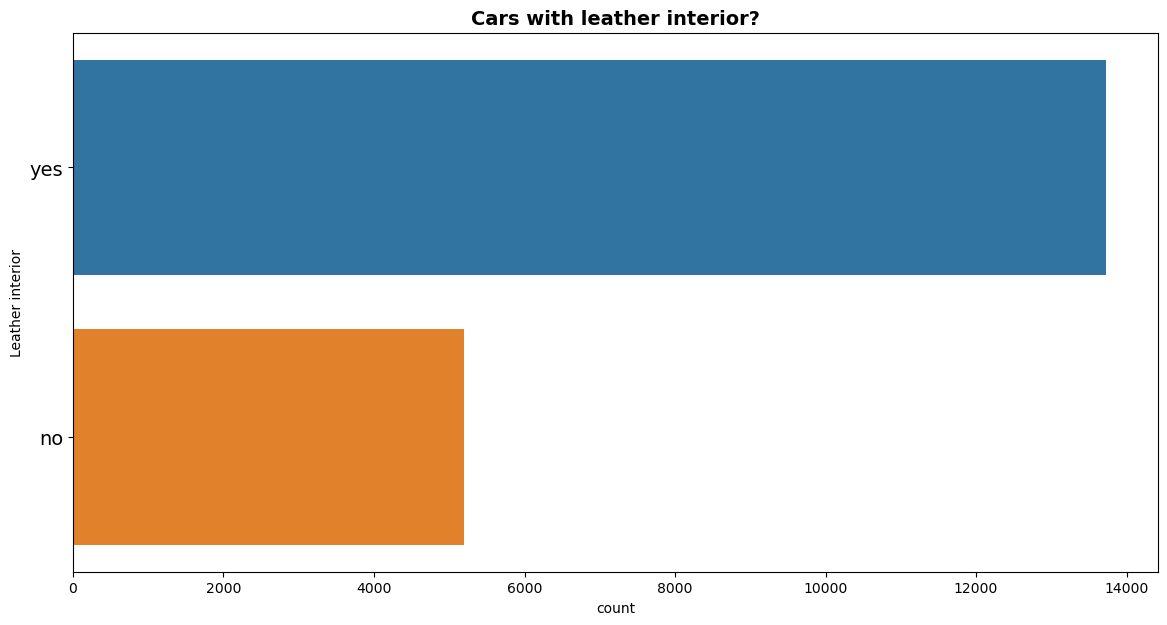

In [66]:
# Cars made up of leather?
plt.figure(figsize=(14,7))
sns.countplot(y=train['Leather interior'], order=train['Leather interior'].value_counts().index)
plt.title('Cars with leather interior?', fontsize=14,fontweight='bold')
plt.yticks(fontsize=14)
plt.show()

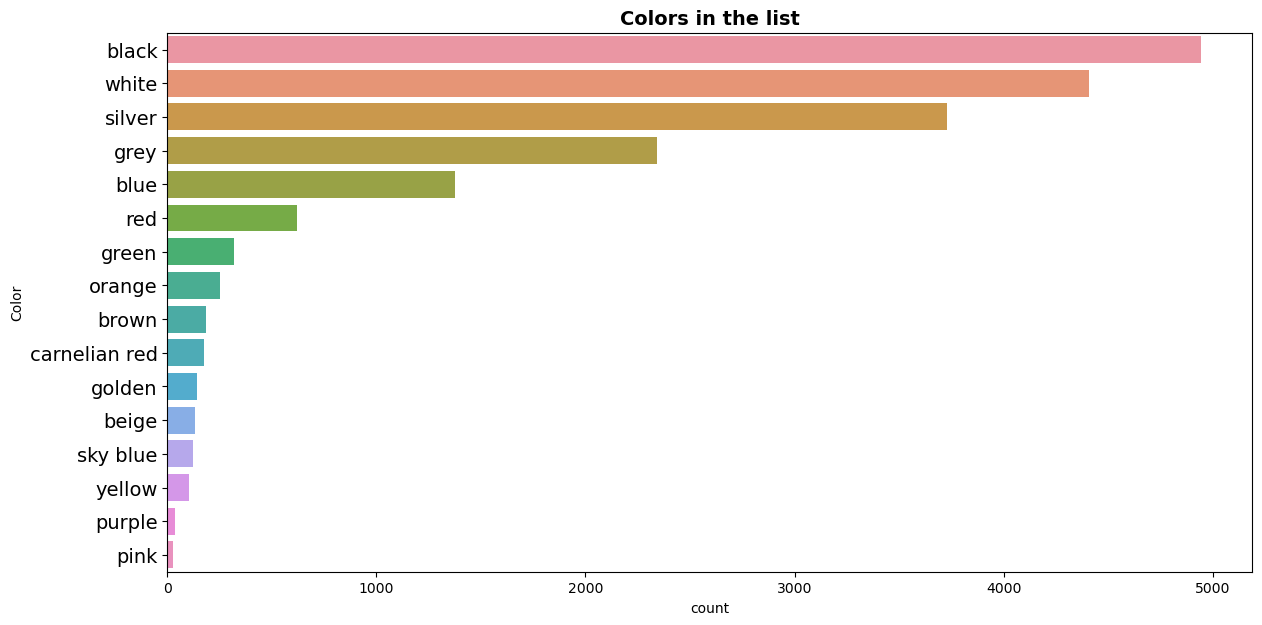

In [67]:
# Most common colors in the list
plt.figure(figsize=(14,7))
sns.countplot(y=train['Color'], order=train['Color'].value_counts().index)
plt.title('Colors in the list', fontsize=14,fontweight='bold')
plt.yticks(fontsize=14)
plt.show()

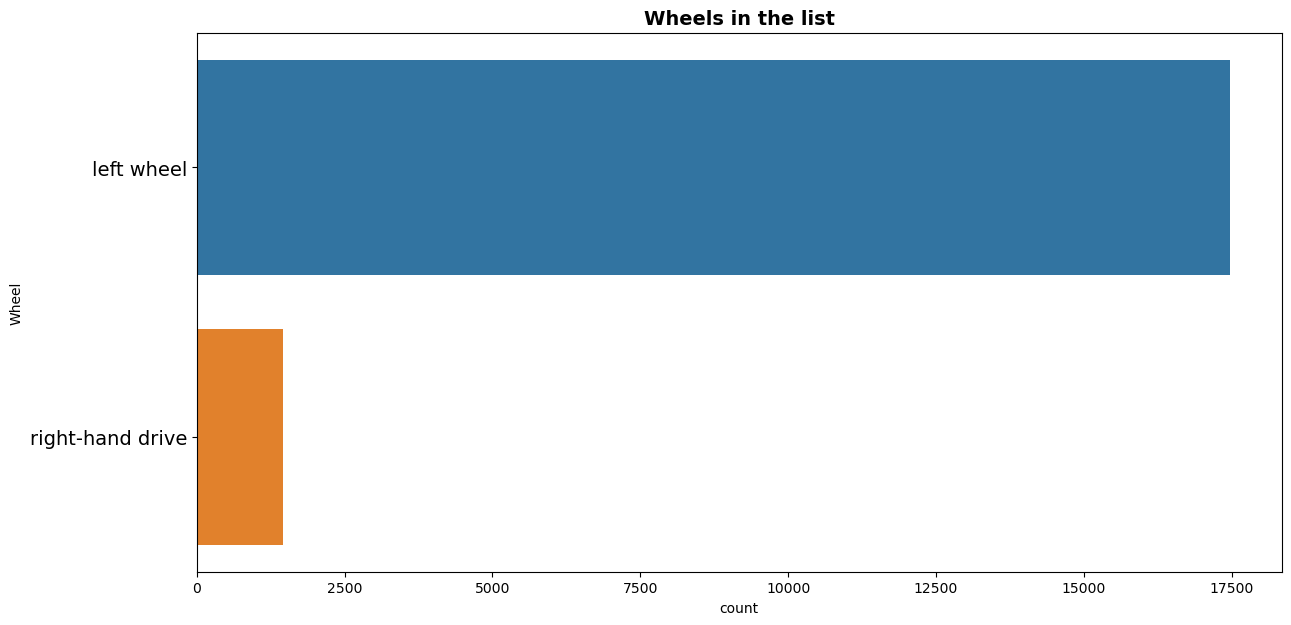

In [68]:
# Most common tires on the list
plt.figure(figsize=(14,7))
sns.countplot(y=train['Wheel'], order=train['Wheel'].value_counts().index)
plt.title('Wheels in the list', fontsize=14,fontweight='bold')
plt.yticks(fontsize=14)
plt.show()

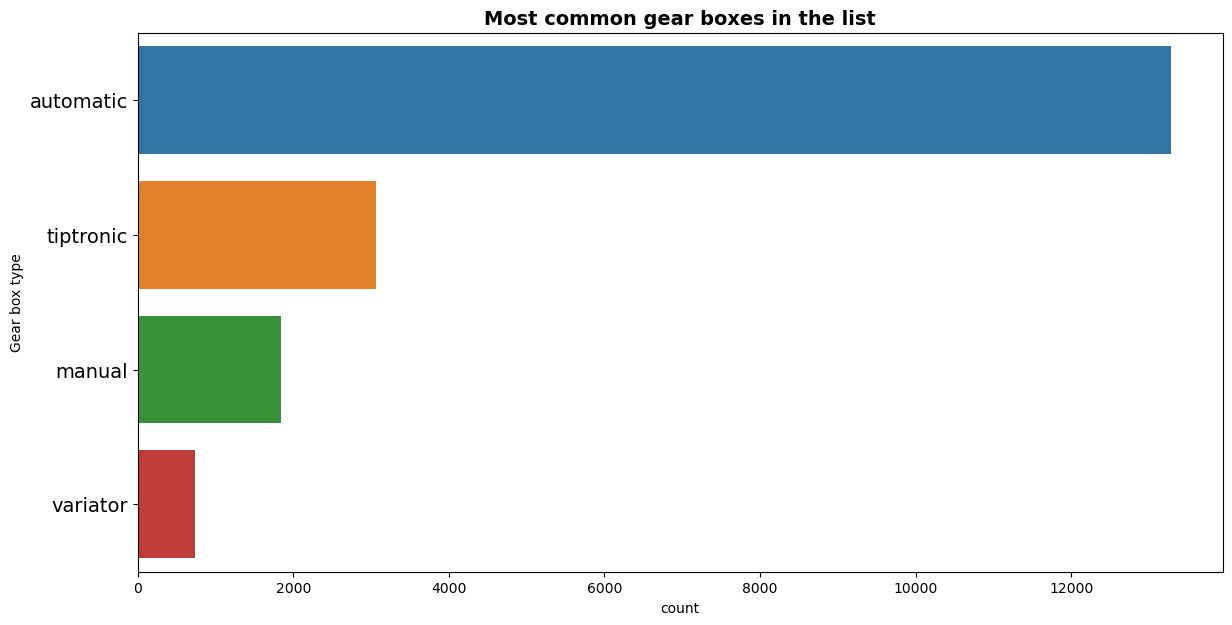

In [69]:
# Most common gears on the list
plt.figure(figsize=(14,7))
sns.countplot(y=train['Gear box type'], order=train['Gear box type'].value_counts().index)
plt.title('Most common gear boxes in the list', fontsize=14,fontweight='bold')
plt.yticks(fontsize=14)
plt.show()

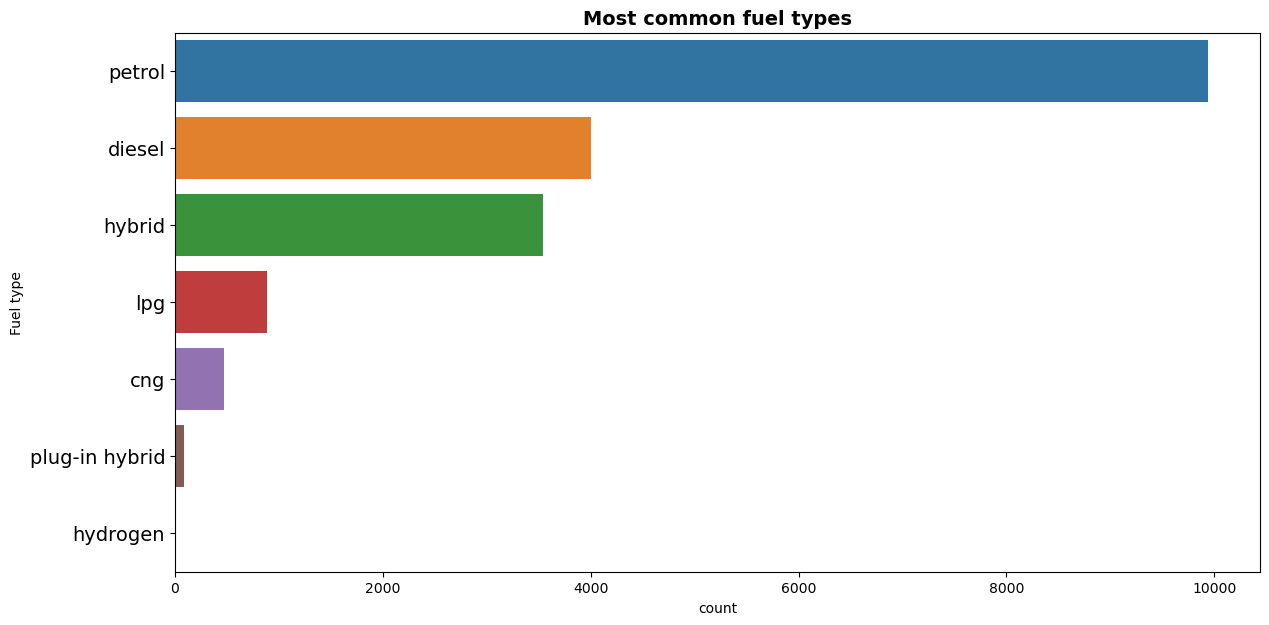

In [70]:
# Most common fuel in the list
plt.figure(figsize=(14,7))
sns.countplot(y=train['Fuel type'], order=train['Fuel type'].value_counts().index)
plt.title('Most common fuel types', fontsize=14,fontweight='bold')
plt.yticks(fontsize=14)
plt.show()

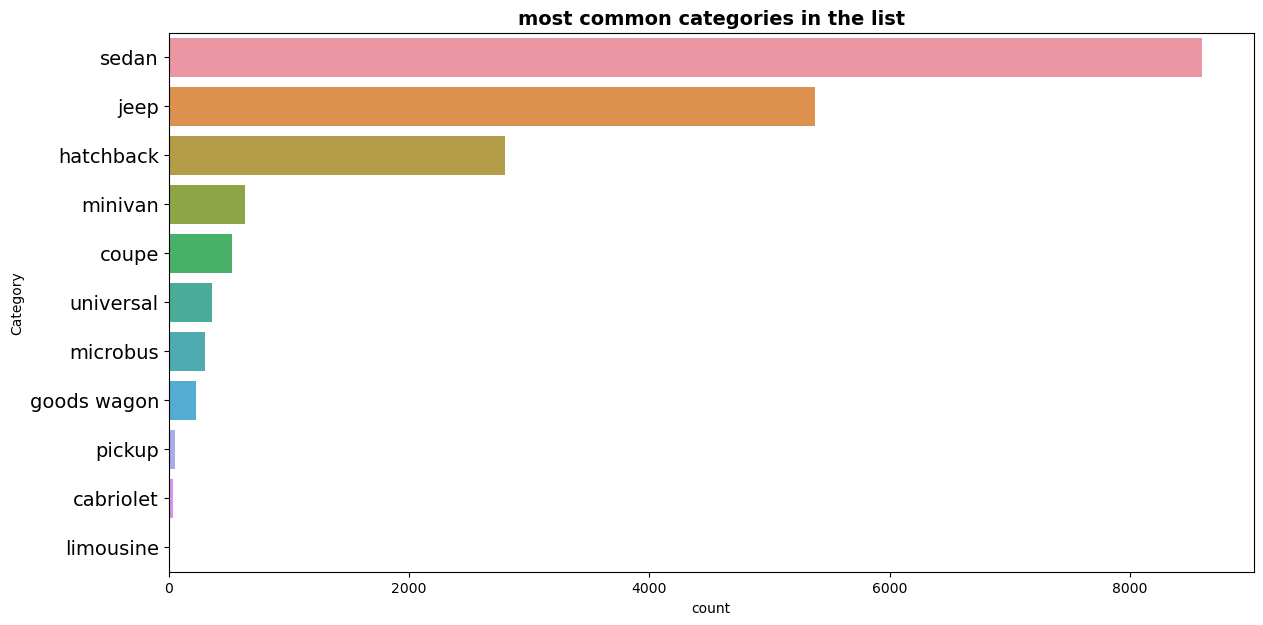

In [71]:
# Most common category in the list
plt.figure(figsize=(14,7))
sns.countplot(y=train['Category'], order=train['Category'].value_counts().index)
plt.title('most common categories in the list', fontsize=14,fontweight='bold')
plt.yticks(fontsize=14)
plt.show()

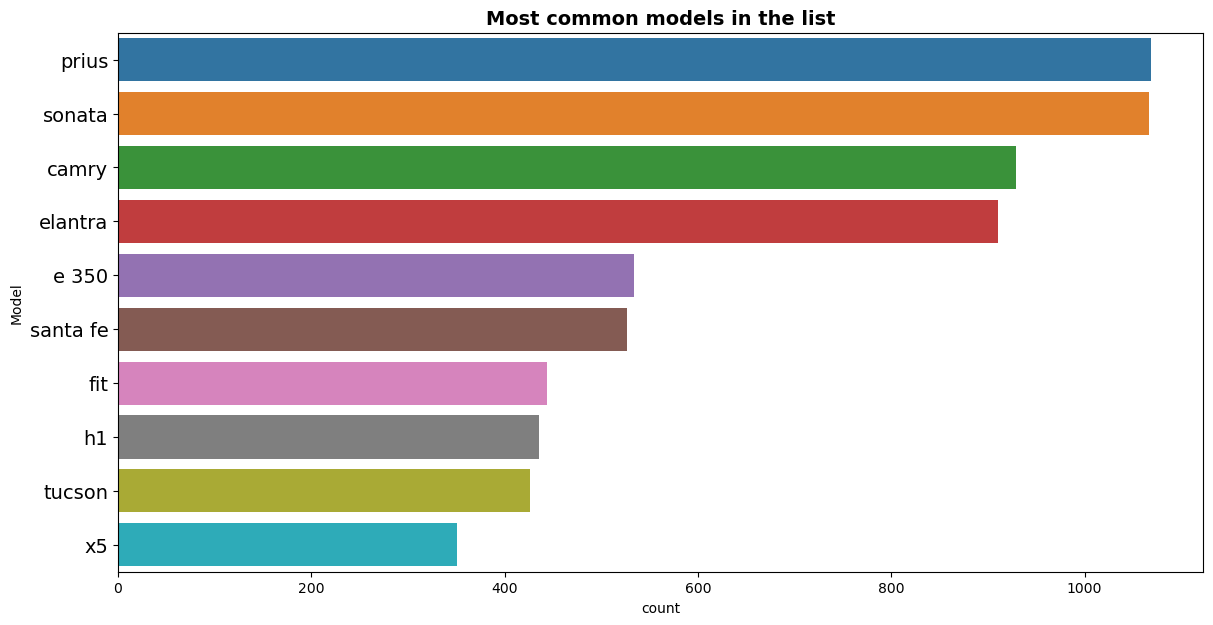

In [72]:
#Most common models in the list
plt.figure(figsize=(14,7))
sns.countplot(y=train['Model'], order=train['Model'].value_counts().index[0:10])
plt.title('Most common models in the list', fontsize=14,fontweight='bold')
plt.yticks(fontsize=14)
plt.show()

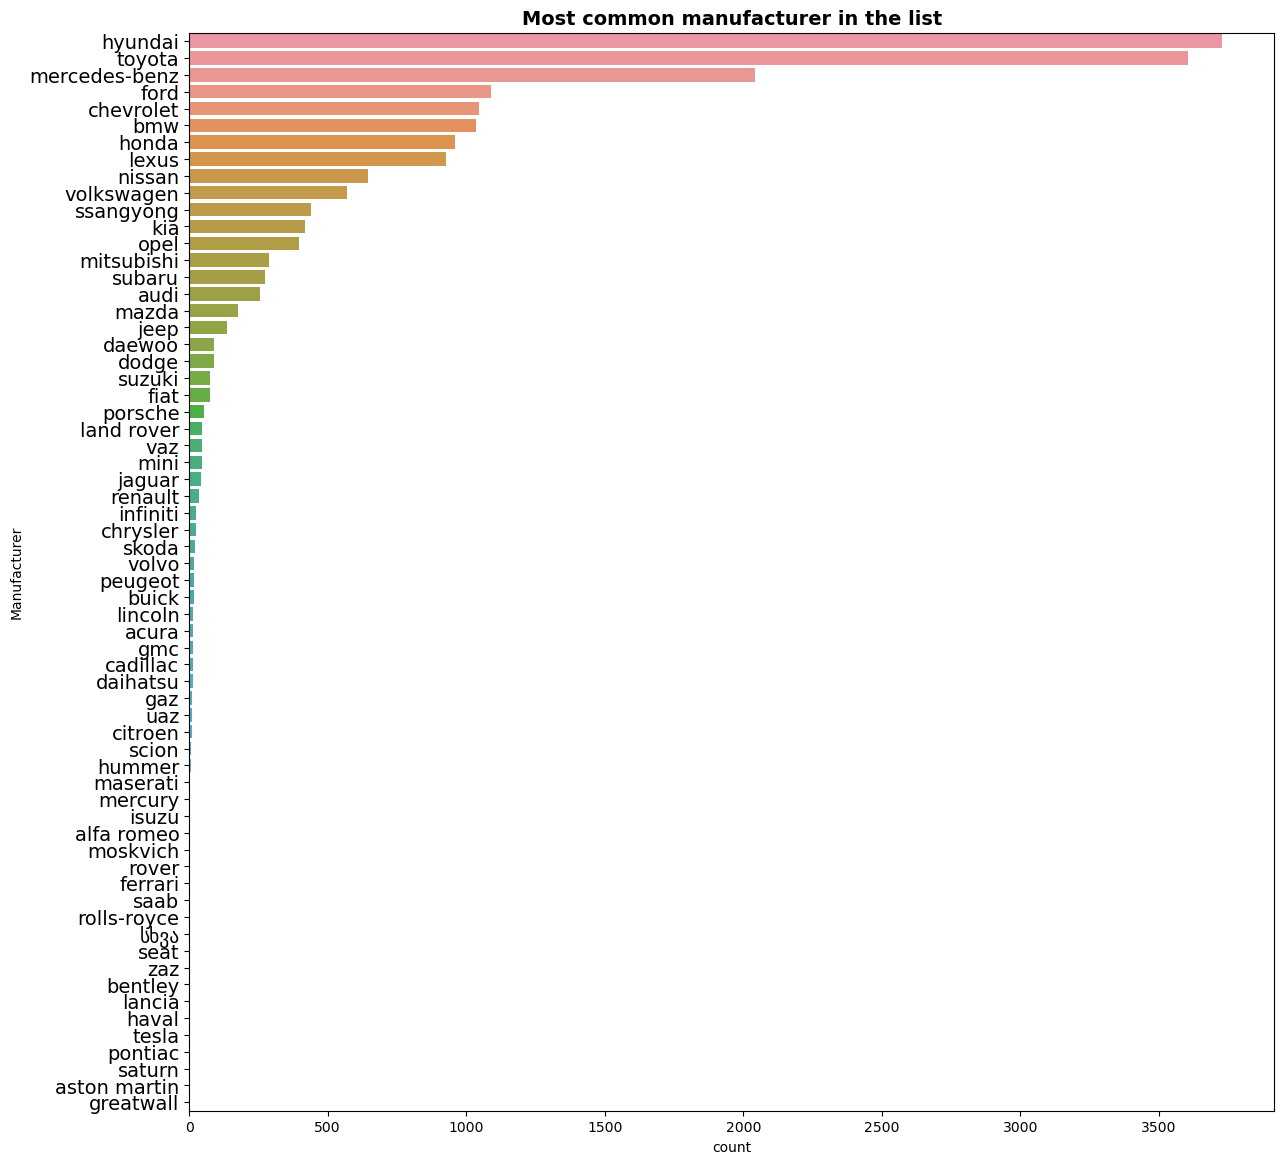

In [73]:
# Most common manufacturer in the list
plt.figure(figsize=(14,14))
sns.countplot(y=train['Manufacturer'], order=train['Manufacturer'].value_counts().index)
plt.title('Most common manufacturer in the list', fontsize=14,fontweight='bold')
plt.yticks(fontsize=14)
plt.show()

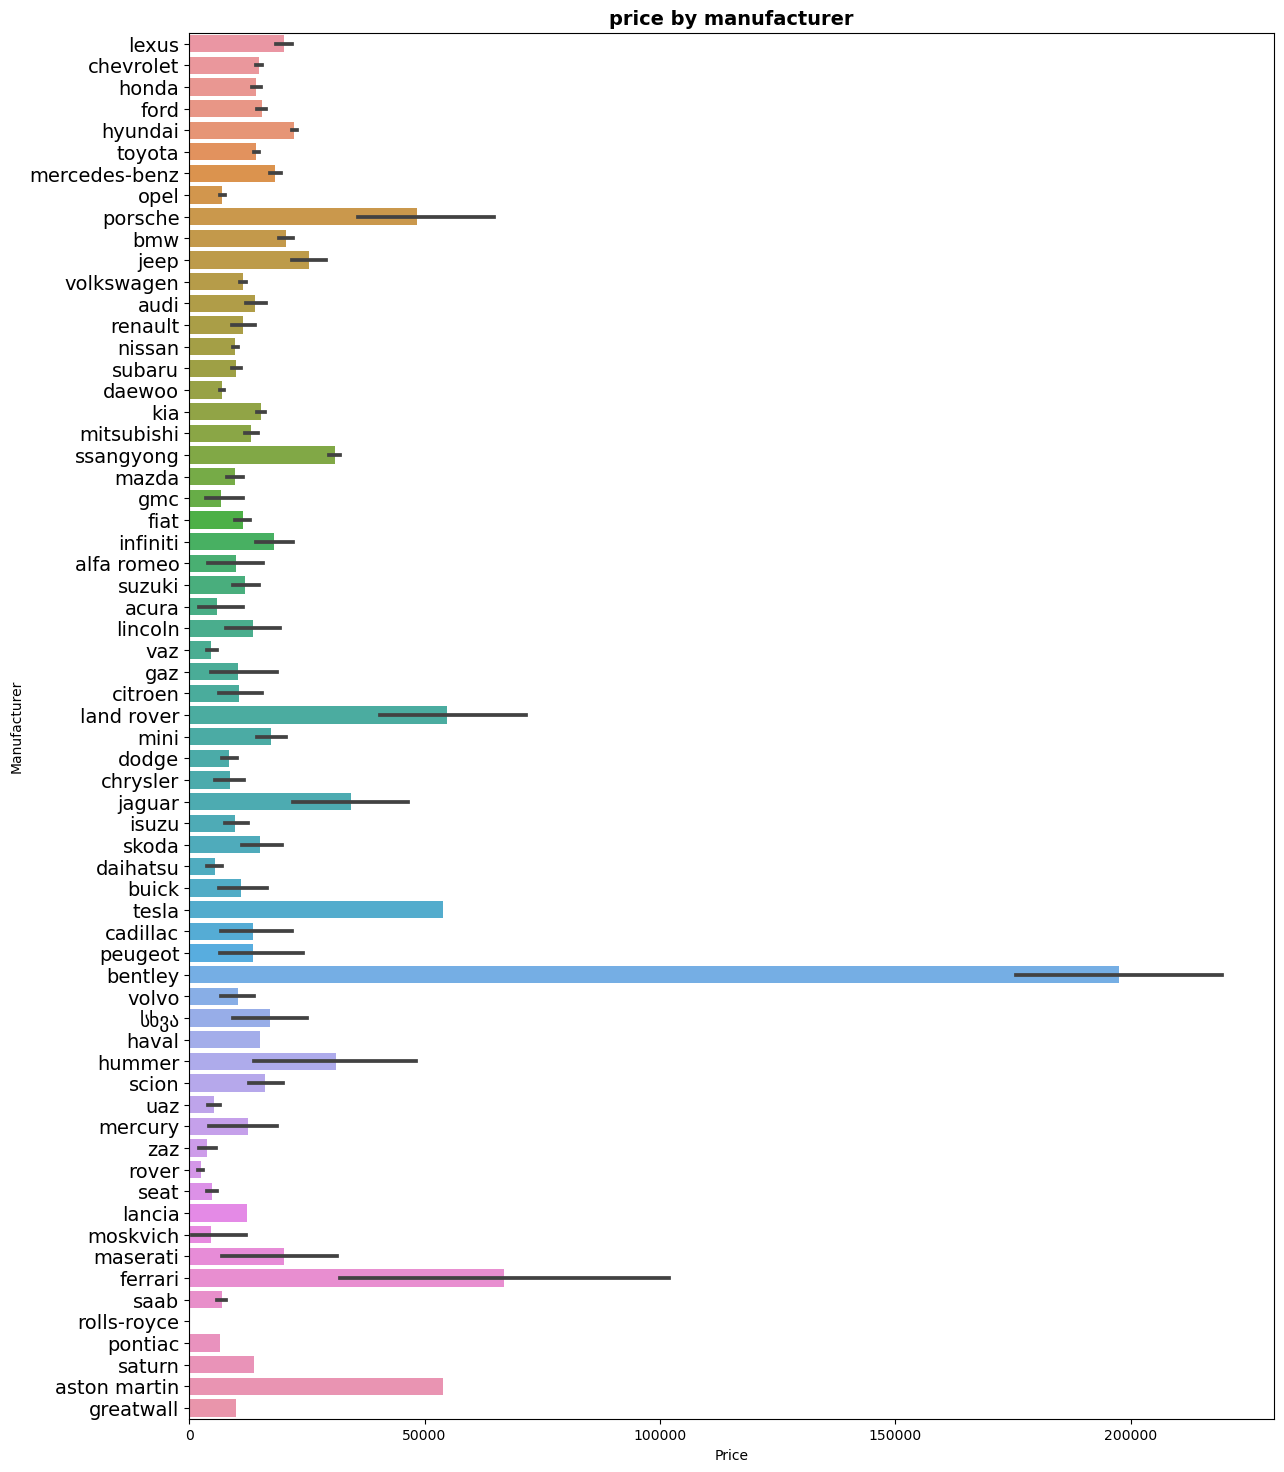

In [74]:
plt.figure(figsize=(14,18))
sns.barplot(y=train['Manufacturer'], x=train['Price'])
plt.title('price by manufacturer', fontsize=14, fontweight='bold')
plt.yticks(fontsize=14)
plt.show()

The most expensive cars are lamborghinis, and then bentley and ferrari come after, we can clearly see the effect of manufacturers on car prices.

Text(0.5, 1.0, 'price in year of production')

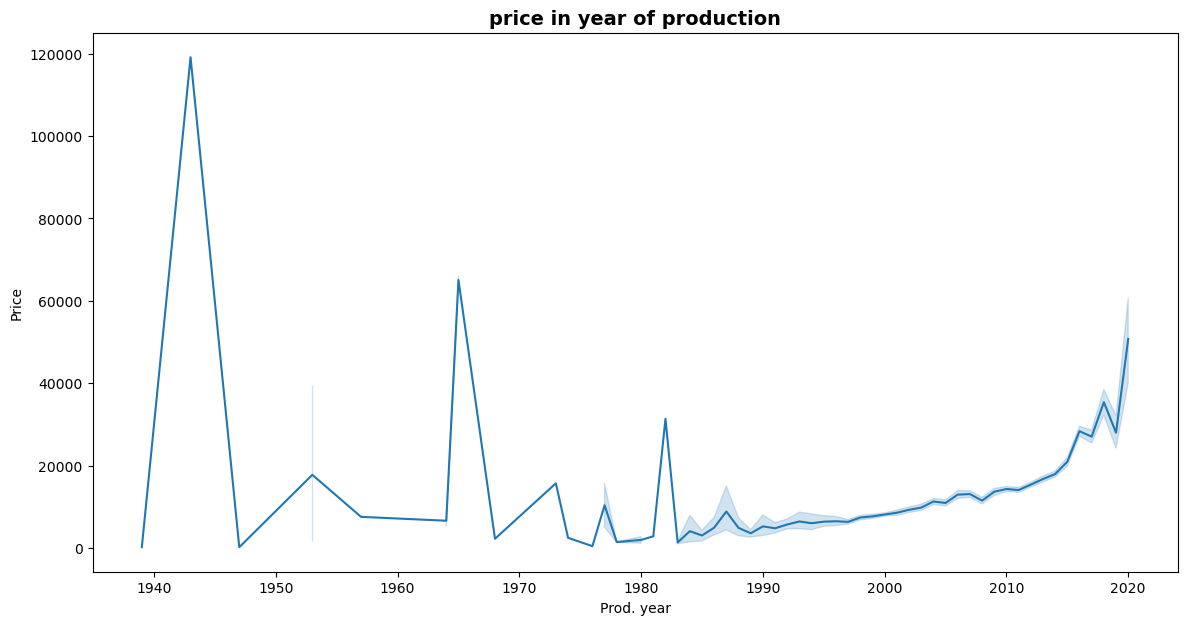

In [76]:
plt.figure(figsize=(14,7))
sns.lineplot(x=train['Prod. year'], y=train['Price'])
plt.title('price in year of production', fontsize=14, fontweight='bold')

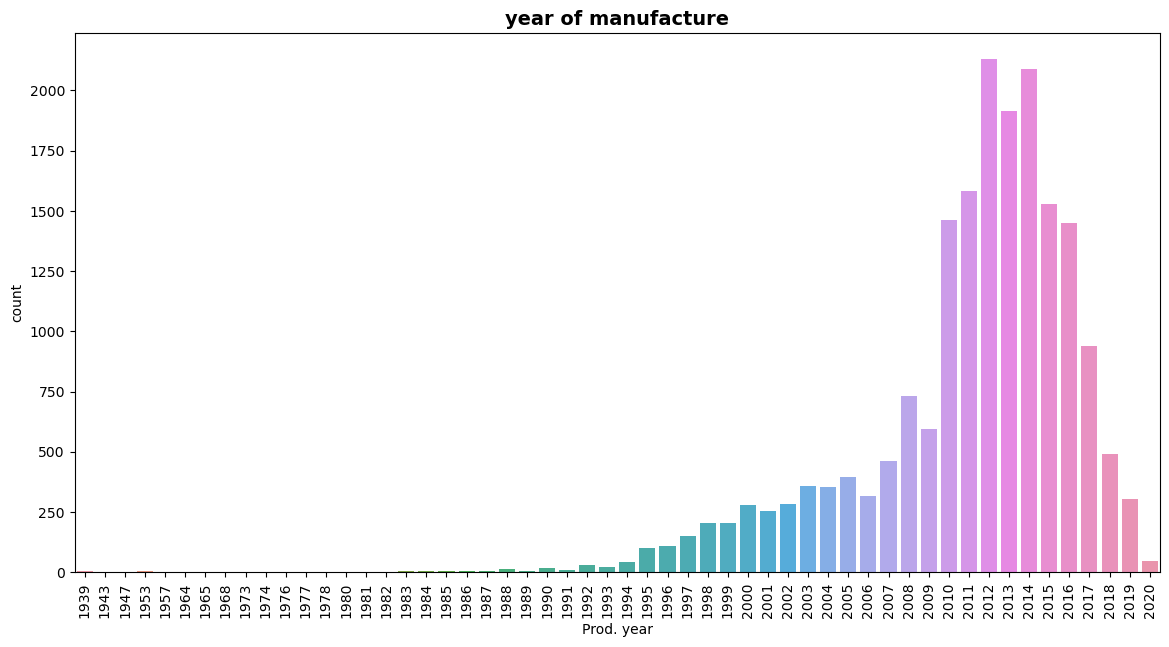

In [77]:
plt.figure(figsize=(14,7))
sns.countplot(x=train['Prod. year'])
plt.title('year of manufacture',fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.show()

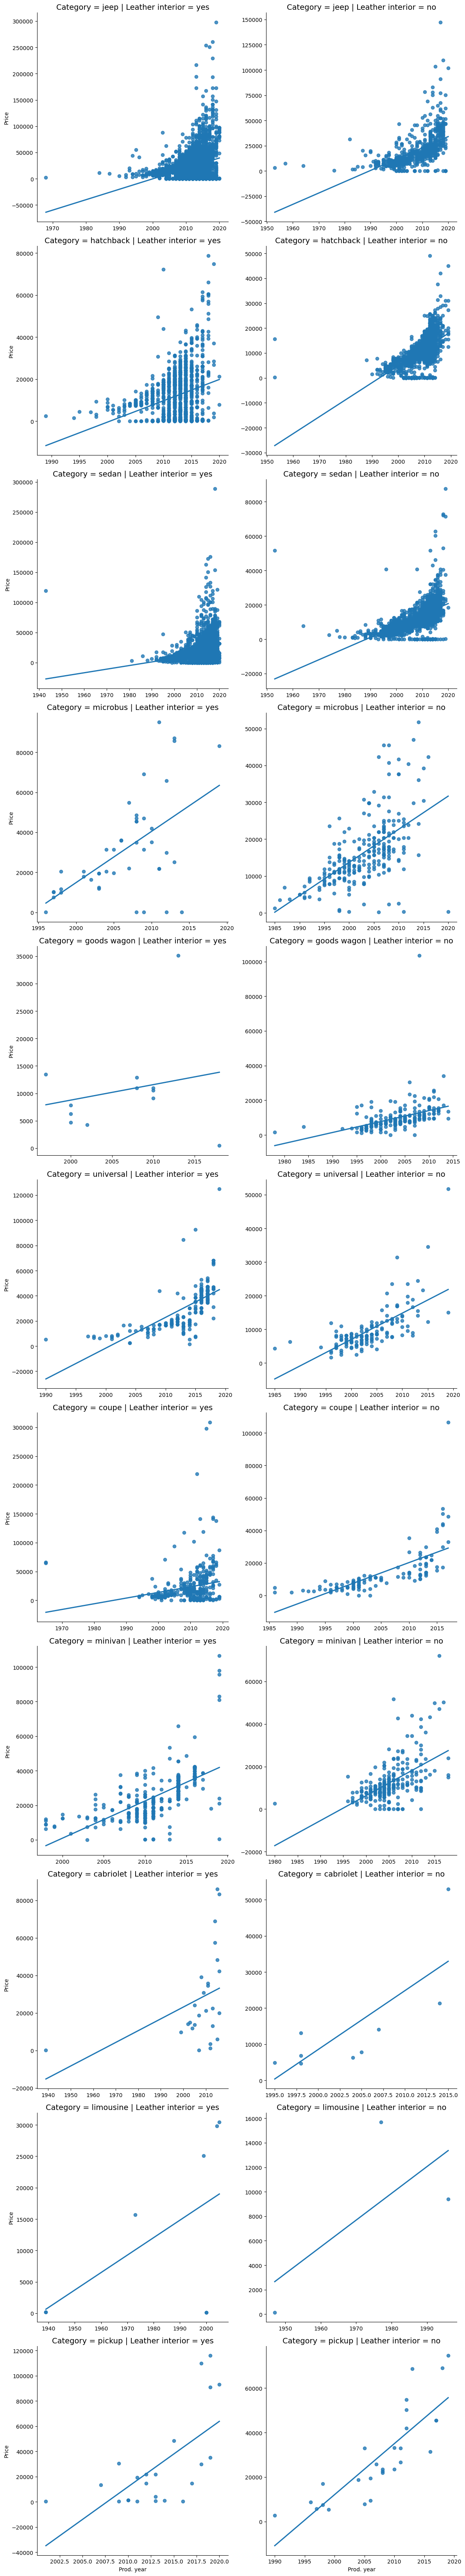

In [79]:
%matplotlib inline  
g = sns.lmplot(data=train, x='Prod. year', y='Price', height=6,
           col='Leather interior', row='Category',facet_kws=dict(sharex=False, sharey=False), ci=None)
g.set_titles(size=14)
g.tight_layout()

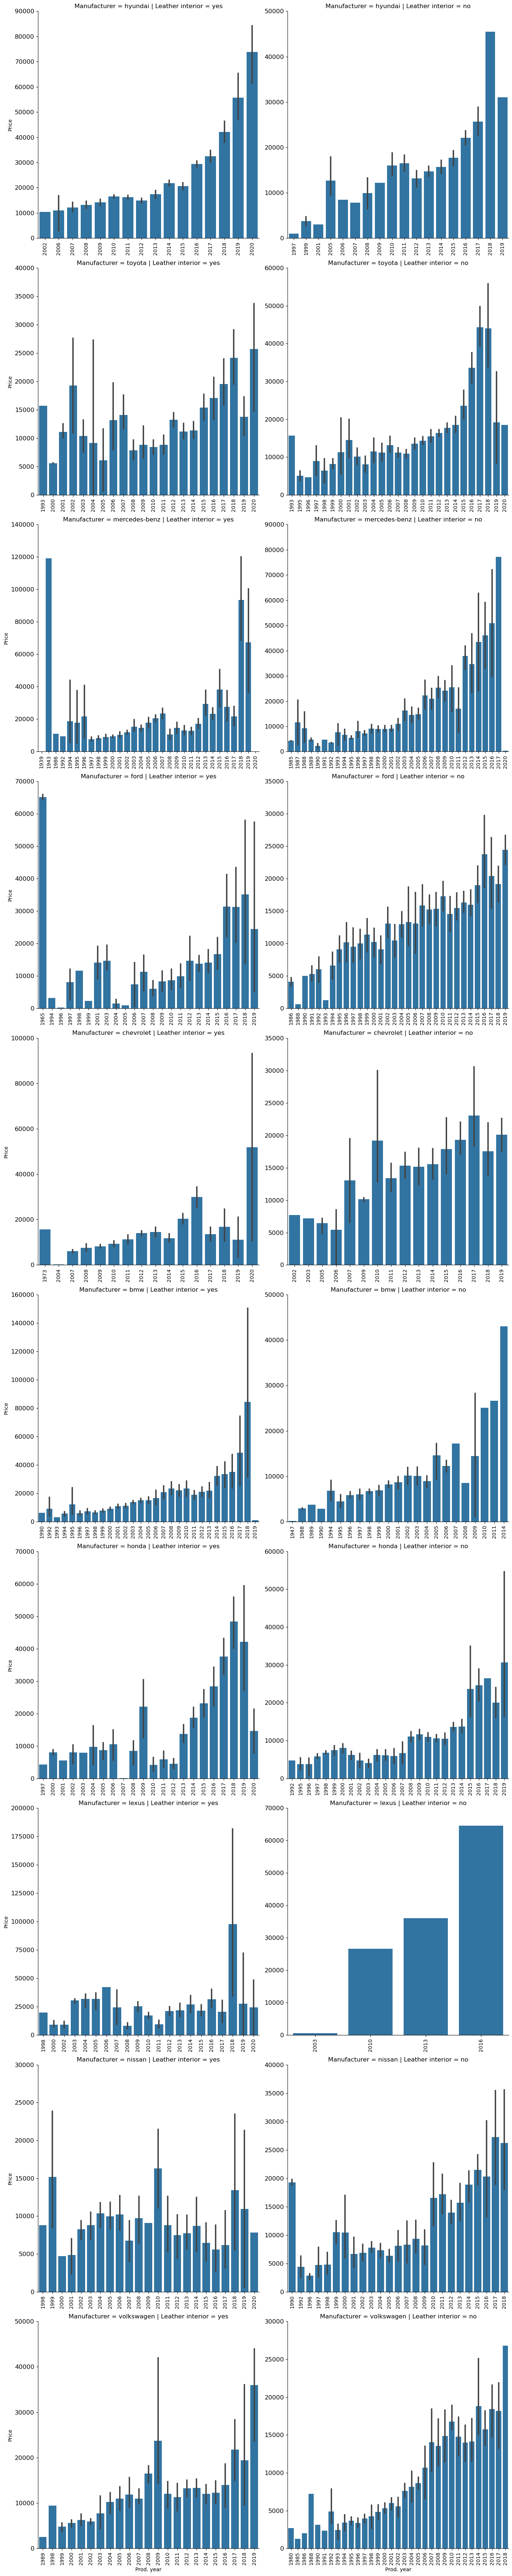

In [83]:
g = sns.FacetGrid(data=train,col='Leather interior', row_order=train['Manufacturer'].value_counts().index[0:10],height=7,
           row='Manufacturer',sharex=False, sharey=False)
g.map_dataframe(sns.barplot, x='Prod. year', y='Price')
g.set_titles(size=12)
g.set_xticklabels(rotation=90)
g.set_yticklabels(fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_1320\265035105.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Prod. year',y='Price',data=train[train['Category'] == m], ci=None)
C:\Users\Admin\AppData\Local\Temp\ipykernel_1320\265035105.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Prod. year',y='Price',data=train[train['Category'] == m], ci=None)
C:\Users\Admin\AppData\Local\Temp\ipykernel_1320\265035105.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Prod. year',y='Price',data=train[train['Category'] == m], ci=None)
C:\Users\Admin\AppData\Local\Temp\ipykernel_1320\265035105.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Prod. year',y='Price',data=train[train['Category'] == m], ci=None)
C:\Users\Admin\AppData\Local

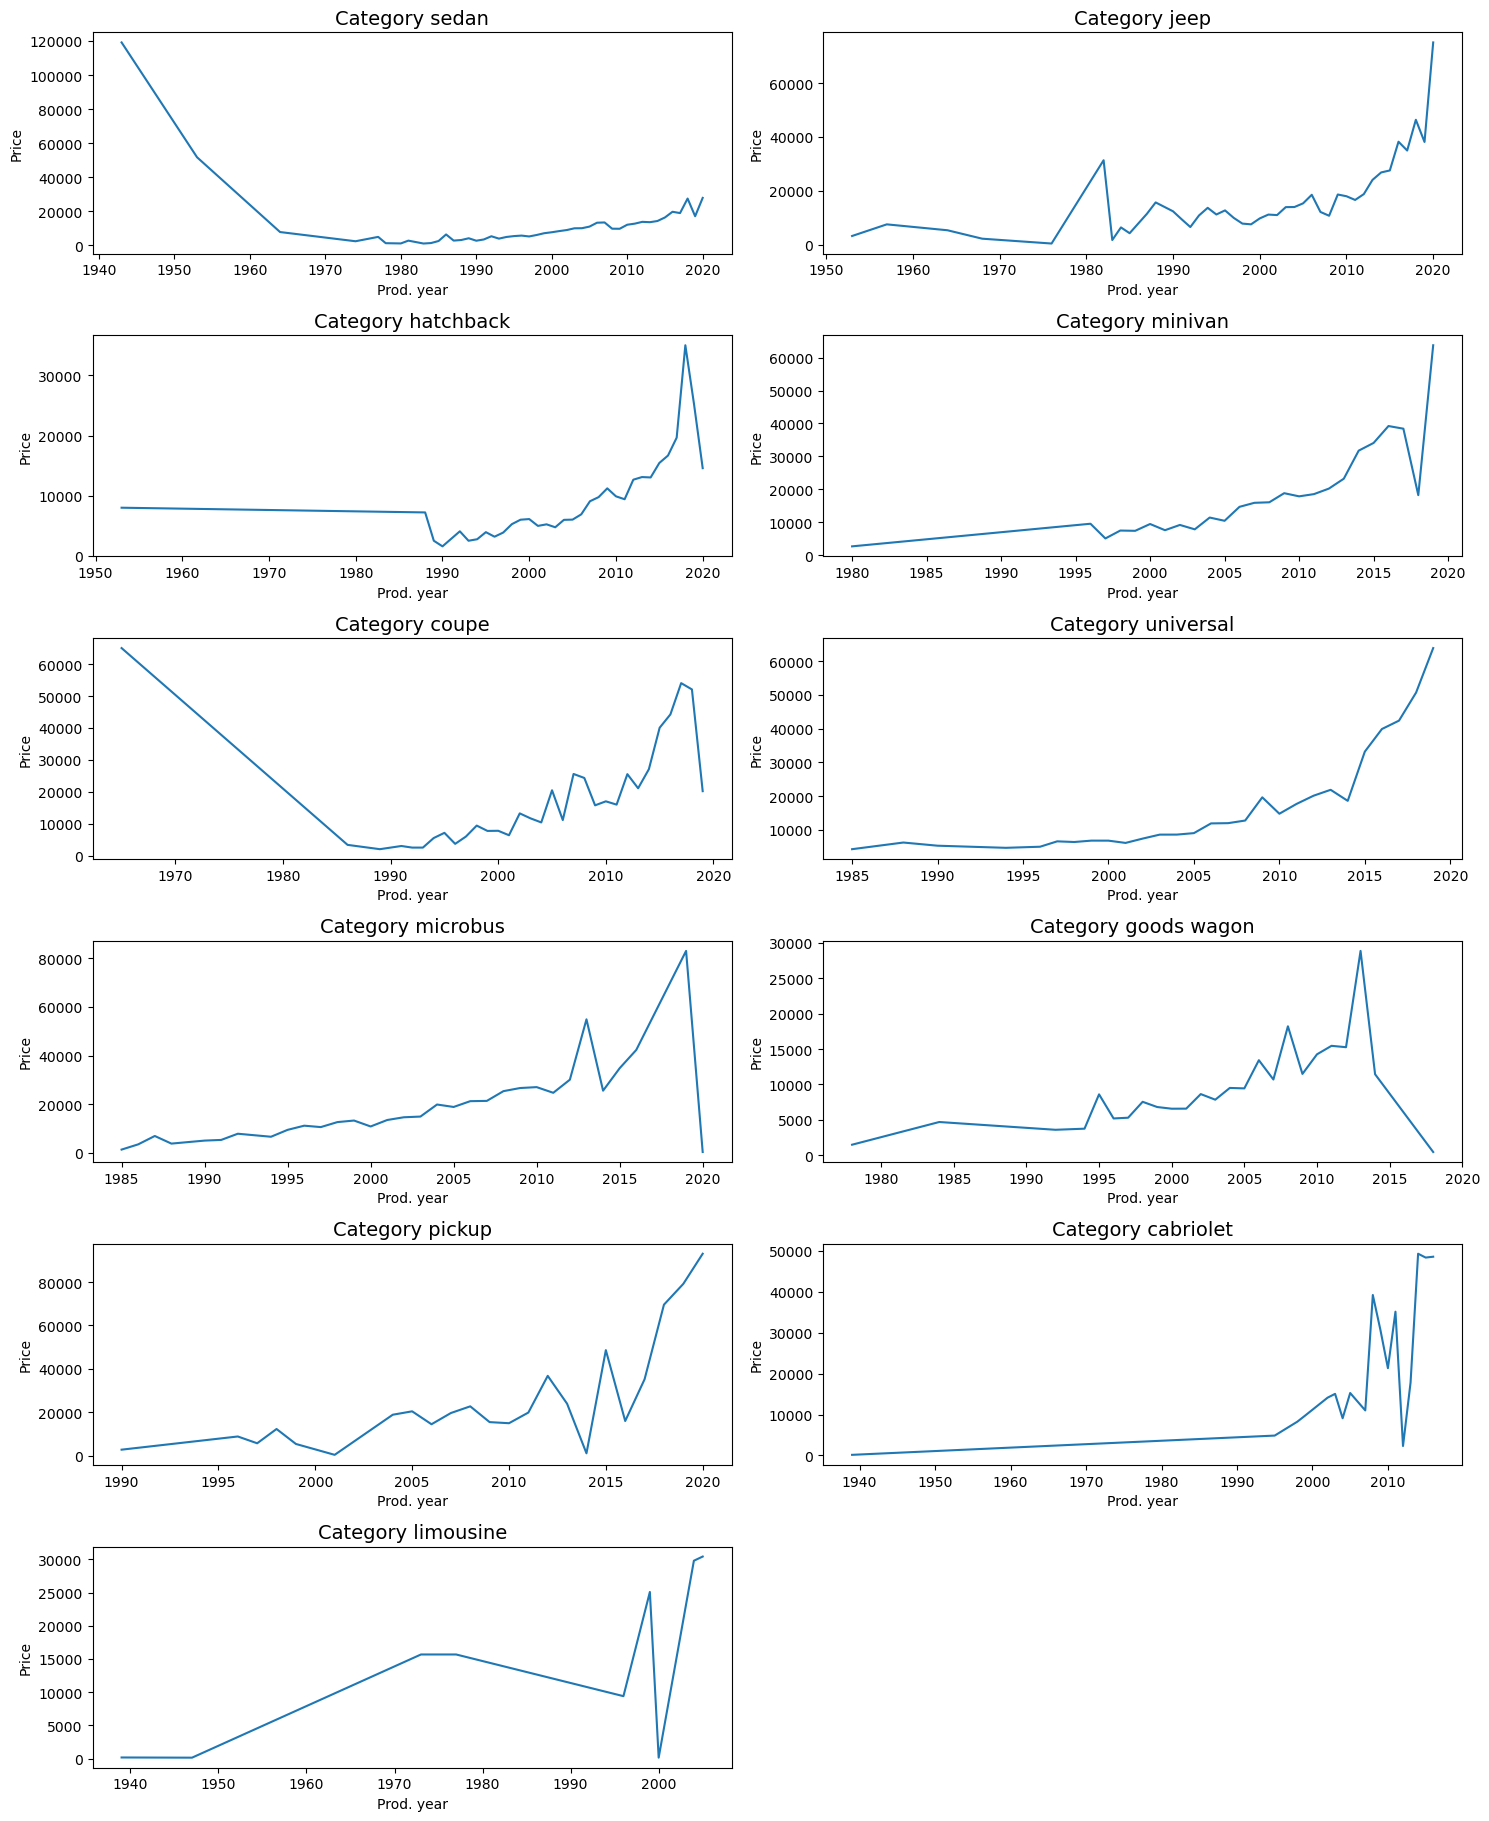

In [80]:
%matplotlib inline  
categoria = train['Category'].value_counts()

plt.figure(figsize=(15,30))
for i,m in enumerate(categoria.index):
    ax = plt.subplot(10,2, i + 1)
    sns.lineplot(x='Prod. year',y='Price',data=train[train['Category'] == m], ci=None)
    plt.title(f'Category {m}', fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_1320\4181132203.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Prod. year',y='Price',data=train[train['Manufacturer'] == m], ci=None)
C:\Users\Admin\AppData\Local\Temp\ipykernel_1320\4181132203.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Prod. year',y='Price',data=train[train['Manufacturer'] == m], ci=None)
C:\Users\Admin\AppData\Local\Temp\ipykernel_1320\4181132203.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Prod. year',y='Price',data=train[train['Manufacturer'] == m], ci=None)
C:\Users\Admin\AppData\Local\Temp\ipykernel_1320\4181132203.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Prod. year',y='Price',data=train[train['Manufacturer'] == m], ci=None)
C:\Users

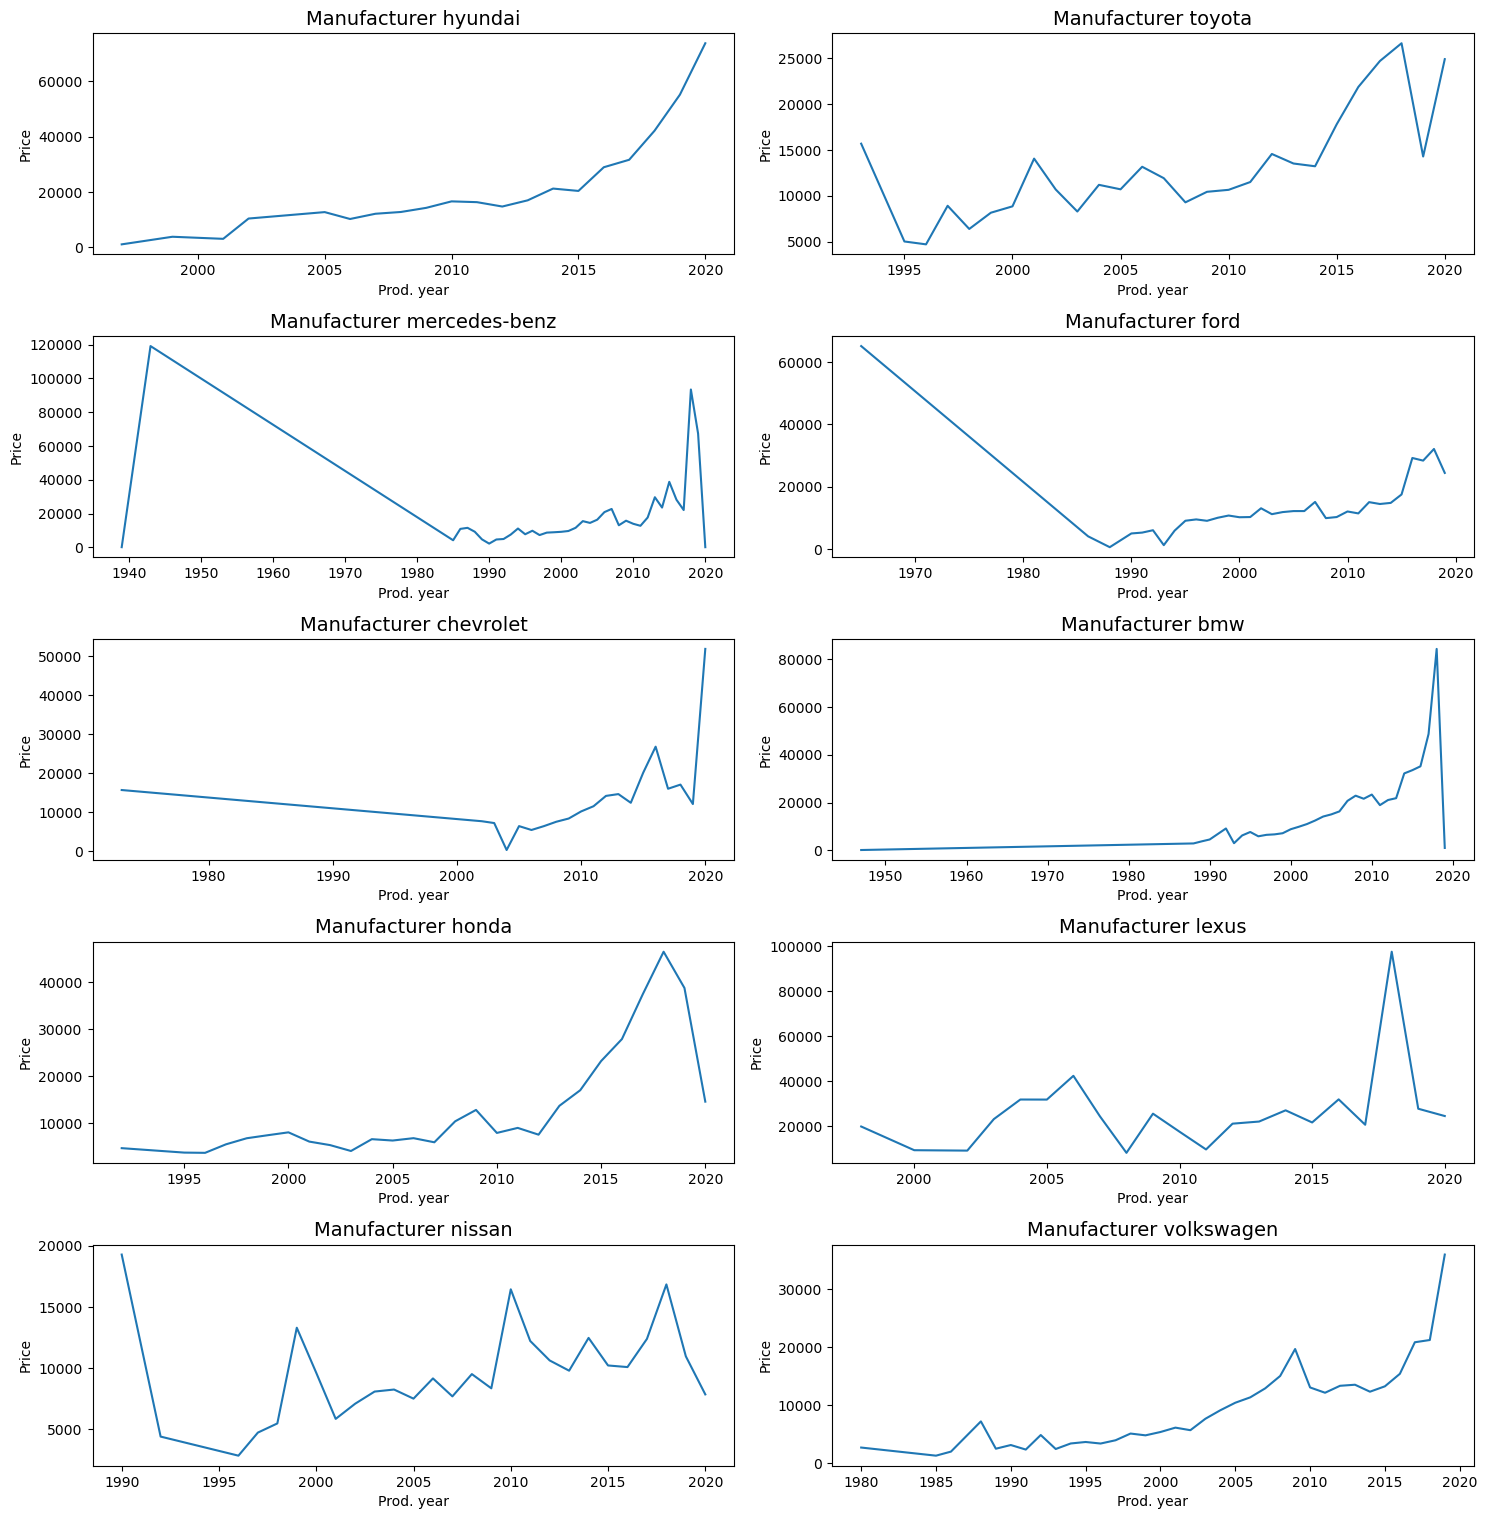

In [81]:
modelos = train['Manufacturer'].value_counts().head(10)

plt.figure(figsize=(15,30))
for i,m in enumerate(modelos.index):
    ax = plt.subplot(10,2, i + 1)
    sns.lineplot(x='Prod. year',y='Price',data=train[train['Manufacturer'] == m], ci=None)
    plt.title(f'Manufacturer {m}', fontsize=14)
plt.tight_layout()
plt.show()

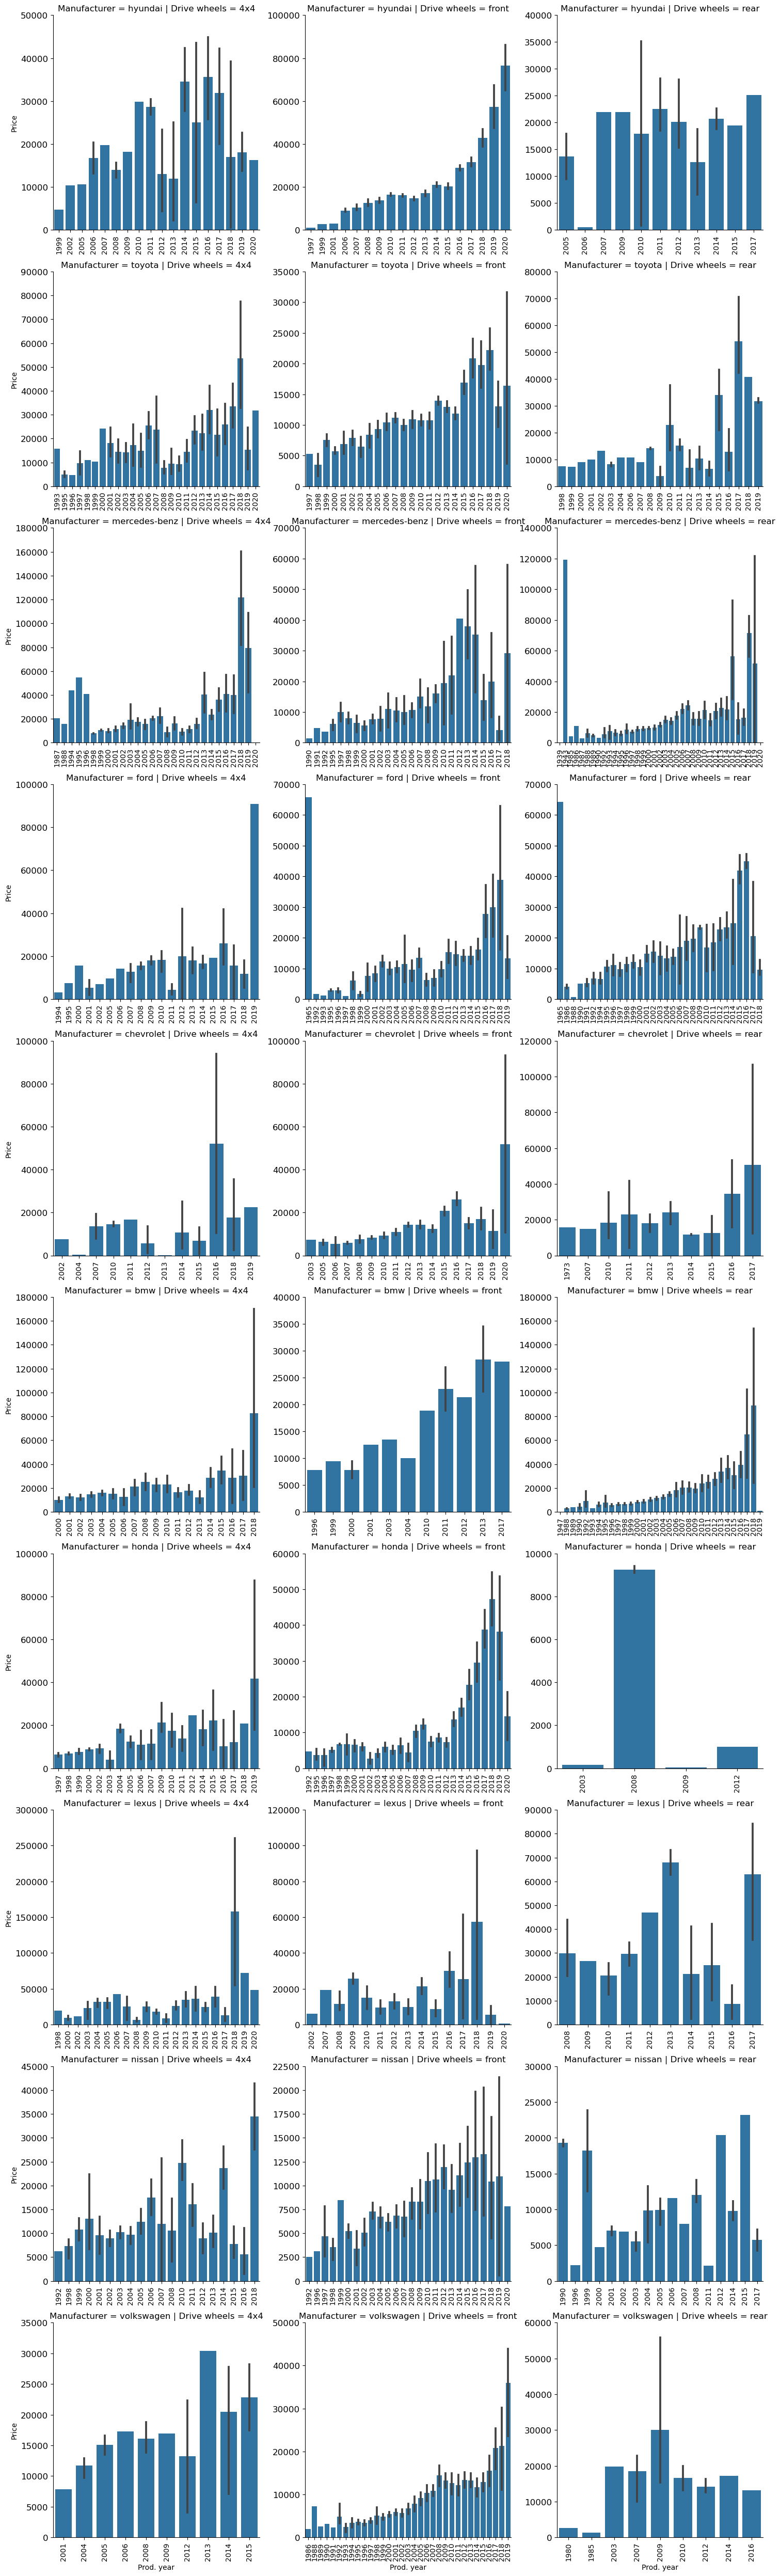

In [82]:
g = sns.FacetGrid(data=train,col='Drive wheels', row_order=train['Manufacturer'].value_counts().index[0:10],height=5,
           row='Manufacturer',sharex=False, sharey=False)
g.map_dataframe(sns.barplot, x='Prod. year', y='Price')
g.set_titles(size=12)
g.set_xticklabels(rotation=90)
g.set_yticklabels(fontsize=12)
plt.tight_layout()
plt.show()

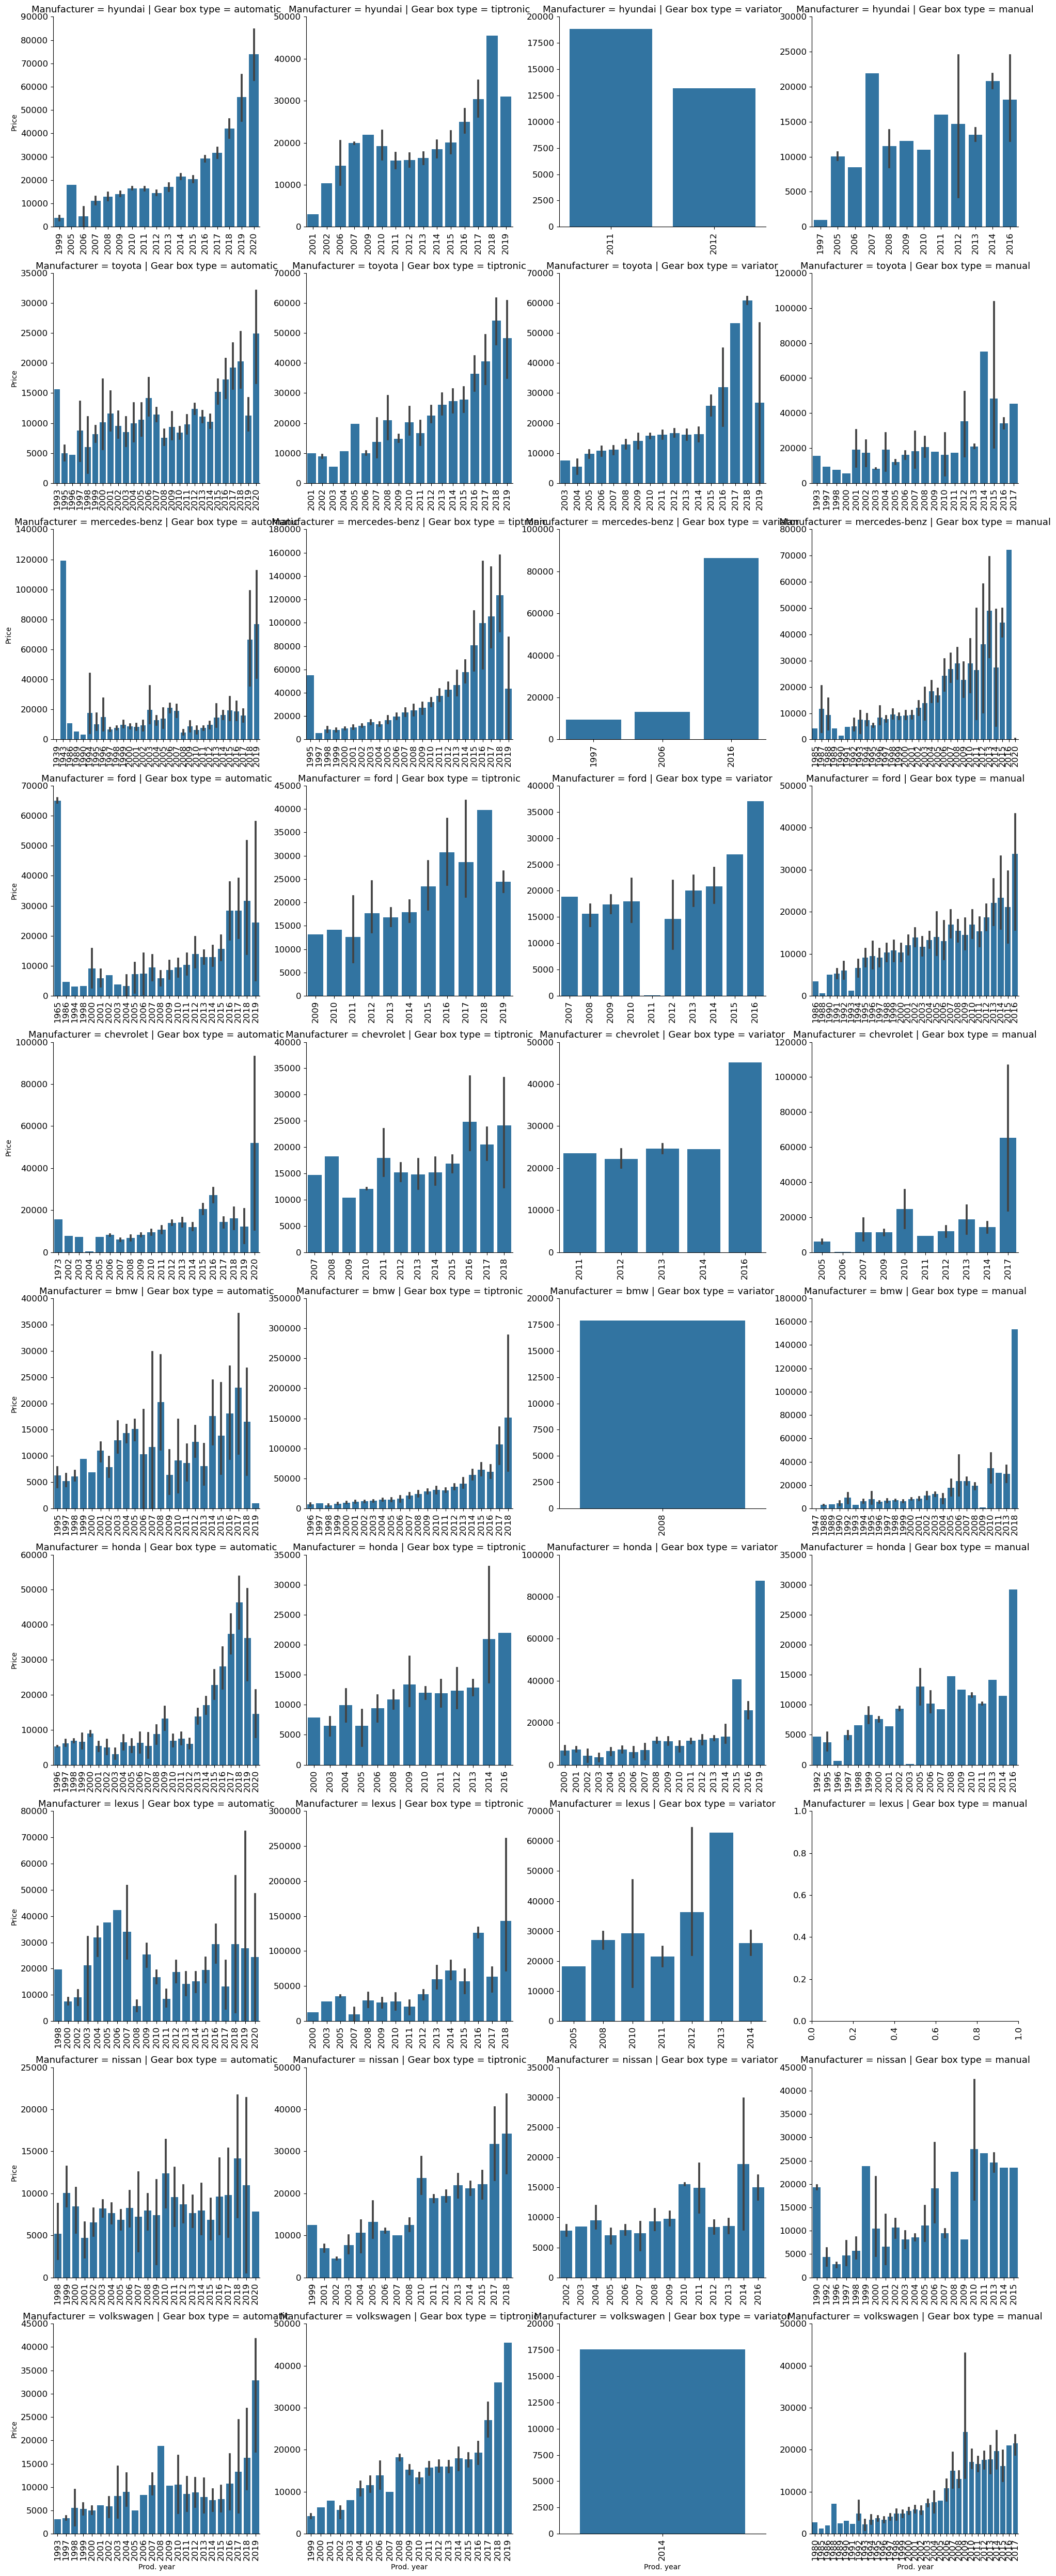

In [84]:
g = sns.FacetGrid(data=train,col='Gear box type', row_order=train['Manufacturer'].value_counts().index[0:10],height=5,
           row='Manufacturer',sharex=False, sharey=False)
g.map_dataframe(sns.barplot, x='Prod. year', y='Price')
g.set_titles(size=13)
g.set_xticklabels(rotation=90, fontsize=12)
g.set_yticklabels(fontsize=12)
plt.tight_layout()
plt.show()

## Data selection

In [85]:
target = df.Price

features = df.drop('Price',axis=1)

scaler = StandardScaler()

## Models

In [86]:
## entry to features, target, test_size,random_state, scaler, n_estimators and max_depth
def model(features,target,Test,random,scaler,n,maxd):
    x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=Test, random_state=random)
    x_train = scaler.fit_transform(x_train) 
    x_test = scaler.fit_transform(x_test)
    
    print('Size Split Train:',x_train.shape, x_test.shape)
    print('Size Split Test:', y_train.shape, y_test.shape)
    print()
    print()
    
    regression = {
        'DECISION':DecisionTreeRegressor(max_depth=maxd),
        'FOREST':RandomForestRegressor(n_estimators=n, max_depth=maxd),
        'GRADIENT':GradientBoostingRegressor(n_estimators=n,max_depth=maxd),
        'EXTRA':ExtraTreesRegressor(n_estimators=n,max_depth=maxd)
    }
    for nome, model in regression.items():
        print('-><-'*20)
        print('Nome:', nome)
        
        model.fit(x_train, y_train)
        y_pred = model.predict(x_train)
        print('Train Score:', model.score(x_train, y_train))
        print('Test Score:', model.score(x_test, y_test))

        plt.scatter(y_train, y_pred, c='green')
        plt.plot([y_train.min(), y_train.max()], [y_train.min(),y_train.max()], c='blue')
        plt.xlabel('Current Value')
        plt.ylabel('Predicted Value')
        plt.show()    

Size Split Train: (15136, 15) (3785, 15)
Size Split Test: (15136,) (3785,)


-><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><-
Nome: DECISION
Train Score: 0.9809343987291752
Test Score: 0.3640793923374088


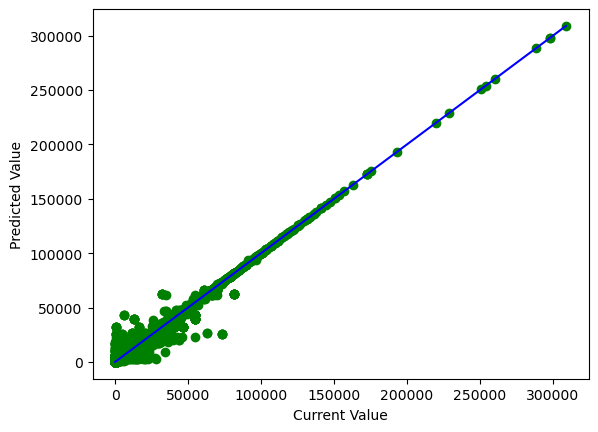

-><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><-
Nome: FOREST
Train Score: 0.9492734008910149
Test Score: 0.6462032246486761


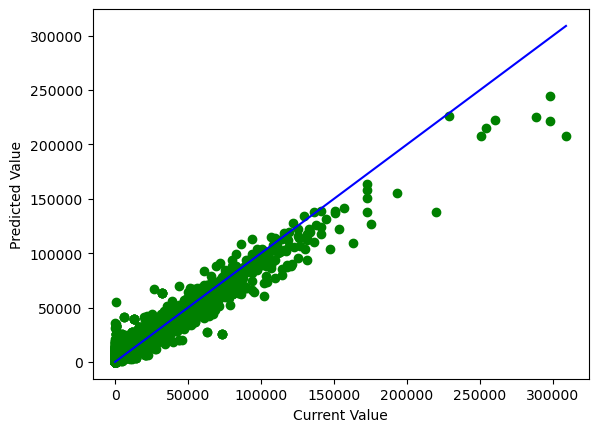

-><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><-
Nome: GRADIENT
Train Score: 0.9885843989875986
Test Score: 0.41448560965760806


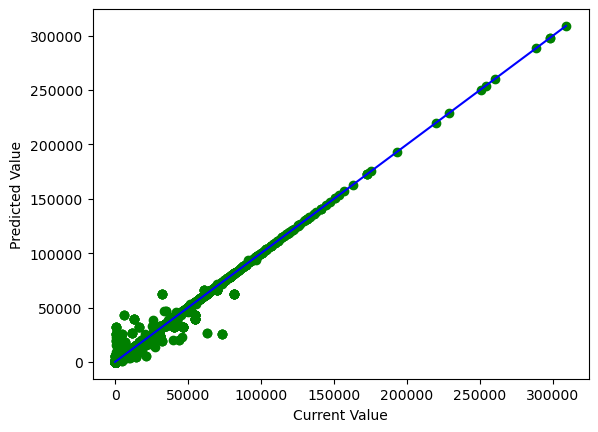

-><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><-
Nome: EXTRA
Train Score: 0.9820969406990715
Test Score: 0.6732448080890381


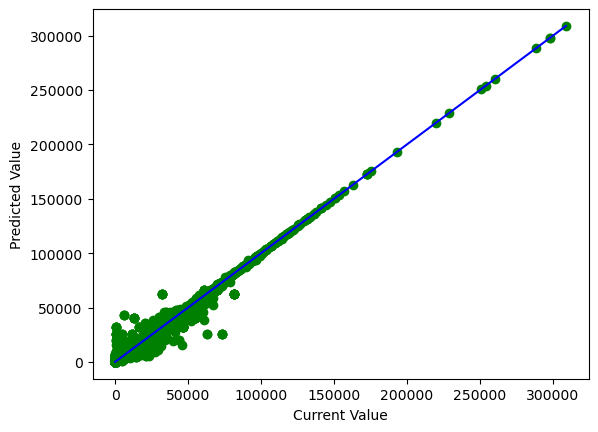

In [87]:
# entry to features, target, test_size, random_state, scaler, n_estimators, max_depth
model(features, target, 0.2, 42,scaler,70, 20)